# Battle of the Neighborhoods

The focus of the project is to use Foursquare data and clustering to determine which US city; Chicago, New York or Los Angeles, is most similar to Toronto.  I will gather lists of neighborhoods and their respective geographic coordinates from various sources online, and use Foursquare to retrieve data on each neighborhood.  I will manipulate and clean the data so that it may be useful for ML, then use clustering and classification to compare Toronto to each US city individually.

In [3]:
# Install / import required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from project_lib import Project
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Watson Studio Project Credentials
project = Project(project_id='', project_access_token='') # Confidential.
pc = project.project_context

Here, I store my credentials for Foursquare.

In [2]:
# Store Foursquare credentials and parameters.
CLIENT_ID = '' # Confidential.
CLIENT_SECRET = '' # Confidential.
VERSION = '20180605'
LIMIT = 100
radius = 500

### Collect Chicago Neighborhoods and Coordinates

I found a good source for Chicago data at **cityofchicago.org**.  The returned JSON file contains neighborhoods and their respective coordinates.

In [5]:
# Retrieve Chicago neighborhood data in JSON format from "cityofchicago.org."
chicago_json_url = urlopen('https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON')
chicago_json = json.loads(chicago_json_url.read())
chicago_dict = {chicago_json['features'][i]['properties']['pri_neigh']:
                chicago_json['features'][i]['geometry']['coordinates'][0][0][0] 
                for i in range(len(chicago_json['features']))}

chicago_json['features'][0]['properties']

{'pri_neigh': 'Grand Boulevard',
 'sec_neigh': 'BRONZEVILLE',
 'shape_area': '48492503.1554',
 'shape_len': '28196.837157'}

In [9]:
# Extract neighborhood name and coordinates from JSON file and create a DataFrame.
chicago_coords = pd.DataFrame(chicago_dict).transpose().reset_index()
chicago_coords.columns = ['Neighborhood', 'Longitude', 'Latitude']
chicago_coords = chicago_coords[['Neighborhood', 'Latitude', 'Longitude']]
chicago_coords.head()

,Neighborhood,Latitude,Longitude
0,Grand Boulevard,41.816814,-87.606708
1,Printers Row,41.874371,-87.627607
2,United Center,41.888852,-87.667069
3,Sheffield & DePaul,41.921661,-87.658335
4,Humboldt Park,41.887823,-87.740596


In [10]:
# Get dimensions of Chicago DataFrame.
chicago_coords.shape

(98, 3)

### Collect Los Angeles Neighborhoods and Coordinates

I found a good source for Los Angeles data at **usc.data.socrata.com**.  The returned JSON file contains neighborhoods and their respective coordinates.

In [11]:
# Retrieve Los Angeles neighborhood data in JSON format from "usc.data.socrata.com."
LA_json_url = urlopen('https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON')
LA_data = json.loads(LA_json_url.read())

LA_data['features'][0]['properties']

{'external_i': 'acton',
 'name': 'Acton',
 'location': 'POINT(34.497355239240846 -118.16981019229348)',
 'latitude': '-118.16981019229348',
 'slug_1': None,
 'sqmi': '39.3391089485',
 'display_na': 'Acton L.A. County Neighborhood (Current)',
 'set': 'L.A. County Neighborhoods (Current)',
 'slug': 'acton',
 'longitude': '34.497355239240846',
 'name_1': None,
 'kind': 'L.A. County Neighborhood (Current)',
 'type': 'unincorporated-area'}

The JSON data for LA is a little different in that it demarks areas as 'unincorporated-area', 'segment-of-a-city' and 'standalone-city'.

In [12]:
# Retrieve all location types from the Los Angeles neighborhood JSON.
mylist = [LA_data['features'][i]['properties']['type'] for i in range(len(LA_data['features']))]
pd.Series(mylist).unique()

array(['unincorporated-area', 'segment-of-a-city', 'standalone-city'],
      dtype=object)

In [13]:
# Extract neighborhood name and coordinates from JSON file and create a DataFrame.
LA_neighborhoods = [LA_data['features'][i]['properties']['name'] 
                    for i in range(len(LA_data['features']))]
LA_latitude = [LA_data['features'][i]['properties']['latitude'] 
               for i in range(len(LA_data['features']))]
LA_longitude = [LA_data['features'][i]['properties']['longitude'] 
                for i in range(len(LA_data['features']))]

LA_coords = pd.DataFrame({'Neighborhood':LA_neighborhoods, 
                          'Latitude':LA_latitude,
                          'Longitude':LA_longitude})
LA_coords.head()

,Neighborhood,Latitude,Longitude
0,Acton,-118.16981019229348,34.497355239240846
1,Adams-Normandie,-118.30020800000011,34.031461499124156
2,Agoura Hills,-118.75988450000015,34.146736499122795
3,Agua Dulce,-118.3171036690717,34.504926999796837
4,Alhambra,-118.13651200000021,34.085538999123571


Seems the longitude and latitude coordinates in the LA JSON file are mis labeled.  That needs to be corrected.

In [14]:
# Re-label latitude and longitude.
LA_coords = pd.DataFrame({'Neighborhood':LA_neighborhoods, 
                          'Latitude':LA_longitude,
                          'Longitude':LA_latitude})
LA_coords.head()

,Neighborhood,Latitude,Longitude
0,Acton,34.497355239240846,-118.16981019229348
1,Adams-Normandie,34.031461499124156,-118.30020800000011
2,Agoura Hills,34.146736499122795,-118.75988450000015
3,Agua Dulce,34.504926999796837,-118.3171036690717
4,Alhambra,34.085538999123571,-118.13651200000021


In [15]:
# Get dimensions of Los Angeles DataFrame.
LA_coords.shape

(272, 3)

### Collect New York Neighborhoods and Coordinates

New York data was used in a previous exercise in this course.  I'll use that.

In [16]:
# Retrieve New York neighborhood data in JSON format from "cocl.us/new_york_dataset."
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [17]:
# Extract neighborhood name and coordinates from JSON file and create a DataFrame.
NY_coords = pd.DataFrame(columns=['Neighborhood', 'Latitude', 'Longitude'])

for data in neighborhoods_data:
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    NY_coords = NY_coords.append({'Neighborhood': neighborhood_name,
                                  'Latitude': neighborhood_lat,
                                  'Longitude': neighborhood_lon},ignore_index=True)
    
NY_coords.head()

,Neighborhood,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


In [19]:
# Get dimensions of New York DataFrame.
NY_coords.shape

(306, 3)

### Collect Toronto Neighborhoods and Coordinates

Like New York, Toronto data was also used in a previous exercise in this course. I'll use that.

In [20]:
# Open target URL.
html = urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# Create BeautifulSoup web-parser.
soup = BeautifulSoup(html, 'html.parser')

# Find attribute table, scrap data and clean text.
table = soup.find('table', {'class': 'wikitable sortable'})
rows = table.find_all('tr')
list_rows = []

for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',str_cells))
    if len(clean2) > 2:
        list_rows.append(clean2.strip('[]')[:-1])
    else:
        continue
        
# Create DataFrame.
df = pd.DataFrame(list_rows)
postalcode_df = df[0].str.split(',', expand=True)
postalcode_df.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Remove rows were "Borough" = "Not Assinged" then group neighborhoods by Borough.
for column in postalcode_df.columns.values:
    postalcode_df[column] = postalcode_df[column].str.strip()

postalcode_df = postalcode_df[postalcode_df.Borough != 'Not assigned'].reset_index(drop=True)
postalcode_df.loc[(postalcode_df.Neighborhood == 'Not assigned'), 'Neighborhood'] = postalcode_df[postalcode_df.Neighborhood == 'Not assigned'].Borough.item()
postalcode_df = postalcode_df.groupby(['PostalCode','Borough']).Neighborhood.unique().apply(lambda x: ', '.join(x)).reset_index()
postalcode_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [21]:
# Read in coordinate data for gathered postal codes.
df = pd.read_csv('https://cocl.us/Geospatial_data')
df.columns = ['PostalCode', 'Latitude', 'Longitude']
df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [22]:
# Replace postal codes with Neighborhood names DataFrames.
toronto_coords = postalcode_df.join(df.set_index('PostalCode'), on='PostalCode')
toronto_coords = toronto_coords.drop(columns=['PostalCode', 'Borough'])
toronto_coords.head()

,Neighborhood,Latitude,Longitude
0,"Rouge, Malvern",43.806686,-79.194353
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Woburn,43.770992,-79.216917
4,Cedarbrae,43.773136,-79.239476


In [23]:
# Get dimensions of Toronto DataFrame.
toronto_coords.shape

(103, 3)

### Retrieve Venues from Foursquare

Now that I have neighborhoods and coordinates for Chicago, Los Angeles, New York and Toronto, I will combine them all into one DataFrame and use that to gather the Foursquare venue data.

In [24]:
# Add "City" column to each city DataFrame.
chicago_coords['City'] = 'Chicago'
LA_coords['City'] = 'Los Angeles'
NY_coords['City'] = 'New York'
toronto_coords['City'] = 'Toronto'

# Concatenate all four city DataFrames.
all_coords = pd.concat([chicago_coords,LA_coords,NY_coords,toronto_coords], axis=0).reset_index(drop=True)
all_coords.head()

,Neighborhood,Latitude,Longitude,City
0,Grand Boulevard,41.8168,-87.6067,Chicago
1,Printers Row,41.8744,-87.6276,Chicago
2,United Center,41.8889,-87.6671,Chicago
3,Sheffield & DePaul,41.9217,-87.6583,Chicago
4,Humboldt Park,41.8878,-87.7406,Chicago


In [23]:
# Check counts of neighborhoods for each city.
all_coords.City.value_counts()

New York       306
Los Angeles    272
Toronto        103
Chicago         98
Name: City, dtype: int64

In [25]:
# Check dimensions of combined DataFrame.
all_coords.shape

(779, 4)

With the combined DataFrame, I can gather the Foursquare venue data.

In [25]:
#Retrieve venue data from Foursquare.
venues_list=[]
for name, lat, lng, city in zip(all_coords['Neighborhood'], 
                          all_coords['Latitude'], 
                          all_coords['Longitude'],all_coords['City']):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name, 
        lat, 
        lng,
        city,
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])


    all_venues_ = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues_.columns = ['Neighborhood', 
                               'Neighborhood Latitude', 
                               'Neighborhood Longitude',
                               'City',
                               'Venue', 
                               'Venue Latitude', 
                               'Venue Longitude', 
                               'Venue Category']


all_venues_.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,City,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Grand Boulevard,41.8168,-87.6067,Chicago,Some Like It Black Creative Arts Bar,41.818432,-87.605251,Juice Bar
1,Grand Boulevard,41.8168,-87.6067,Chicago,Just Turkey Restaurant,41.815248,-87.606212,BBQ Joint
2,Grand Boulevard,41.8168,-87.6067,Chicago,Norman's Bistro,41.816795,-87.601809,Restaurant
3,Grand Boulevard,41.8168,-87.6067,Chicago,Honey 1 BBQ,41.816910,-87.607320,BBQ Joint
4,Grand Boulevard,41.8168,-87.6067,Chicago,Family Dollar,41.813800,-87.606318,Discount Store


So I do not need to make API calls every time I work on this, I will save the full venues DataFrame as a csv file.

In [32]:
# Save DataFrame as csv in Watson Studio project files.
project.save_data(data=all_venues_.to_csv(index=False),file_name='all_venues.csv',overwrite=True)

{'file_name': 'all_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracapstonebattleoftheneighb-donotdelete-pr-bhmhnb8jotwbru',
 'asset_id': 'd0322822-1ae6-4ffd-962a-1e666003d07e'}

Now I can retrieve the data without API calls.

In [26]:
# Read in "all_venues.csv" file.
all_venues_ = pd.read_csv(project.get_file('all_venues.csv'))
all_venues_.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,City,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Grand Boulevard,41.816814,-87.606708,Chicago,Some Like It Black Creative Arts Bar,41.818432,-87.605251,Juice Bar
1,Grand Boulevard,41.816814,-87.606708,Chicago,Just Turkey Restaurant,41.815248,-87.606212,BBQ Joint
2,Grand Boulevard,41.816814,-87.606708,Chicago,Norman's Bistro,41.816795,-87.601809,Restaurant
3,Grand Boulevard,41.816814,-87.606708,Chicago,Honey 1 BBQ,41.816910,-87.607320,BBQ Joint
4,Grand Boulevard,41.816814,-87.606708,Chicago,Family Dollar,41.813800,-87.606318,Discount Store


In [5]:
# Check Dimensions of "all_venues_" DataFrame.
all_venues_.shape

(17931, 8)

With Foursquare, it is possible that there are venues with overlapping neighborhoods.  I want to eliminate the duplicates so each venue only appears once.

In [6]:
# Create a copy of the venus DataFrame so I can keep a clean, unedited original.
all_venues = all_venues_.copy()

# Check DataFrame for duplicate venue entries.
all_venues['Dup'] = (all_venues.duplicated(subset=['Venue Longitude', 'Venue Latitude', 'Venue'], keep=False))
all_venues[all_venues.Dup == True].sort_values('Venue').head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,City,Venue,Venue Latitude,Venue Longitude,Venue Category,Dup
1738,Hyde Park,41.793487,-87.579301,Chicago,#55 Bus Stop,41.794773,-87.583568,Bus Station,True
511,Jackson Park,41.793395,-87.579302,Chicago,#55 Bus Stop,41.794773,-87.583568,Bus Station,True
10772,Soho,40.722184,-74.000657,New York,19 Cleveland,40.721608,-73.997249,Mediterranean Restaurant,True
10647,Little Italy,40.719324,-73.997305,New York,19 Cleveland,40.721608,-73.997249,Mediterranean Restaurant,True
8311,Boerum Hill,40.685683,-73.983748,New York,2 Bros. Pizza,40.689394,-73.981125,Pizza Place,True
8214,Downtown,40.690844,-73.983463,New York,2 Bros. Pizza,40.689394,-73.981125,Pizza Place,True
14869,Tudor City,40.746917,-73.971219,New York,251 Ginza Sushi,40.745567,-73.975706,Sushi Restaurant,True
10153,Murray Hill,40.748303,-73.978332,New York,251 Ginza Sushi,40.745567,-73.975706,Sushi Restaurant,True
689,Museum Campus,41.867473,-87.612347,Chicago,4-D Experience,41.867347,-87.613256,Movie Theater,True
978,Grant Park,41.867587,-87.618891,Chicago,4-D Experience,41.867347,-87.613256,Movie Theater,True


In [7]:
# Check count of duplicate entries.
len(all_venues[all_venues.Dup == True])

2377

In [8]:
# Check count of duplicate entries that will be deleted if we keep only one from each set of duplicates.
all_venues['Dup'] = (all_venues.duplicated(subset=['Venue Longitude', 'Venue Latitude', 'Venue'], keep='first'))
len(all_venues[all_venues.Dup == True])

1303

In [9]:
# Remove duplicate entries keeping only one.
all_venues = all_venues.drop_duplicates(subset=['Venue Longitude', 'Venue Latitude', 'Venue'], keep='first')

# Check dimensions of new DataFrame.
all_venues.shape

(16628, 9)

Now there is only one of each venue entry.

Next, I saw there are some entries with a *Venue Category* of "Neighborhood".  These  will be confusing once I prep the data for ML, so I will remove them.

In [10]:
# Show all entries where Venue Category is "Neighborhood".
all_venues[all_venues['Venue Category'] == 'Neighborhood']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,City,Venue,Venue Latitude,Venue Longitude,Venue Category,Dup
3334,Downtown,34.040009,-118.248510,Los Angeles,Los Angeles Flower District,34.039336,-118.249496,Neighborhood,False
3470,El Sereno,34.082242,-118.176298,Los Angeles,El Sereno,34.085806,-118.177146,Neighborhood,False
3977,Jefferson Park,34.028211,-118.322059,Los Angeles,Jefferson Park,34.024528,-118.319029,Neighborhood,False
6828,Brighton Beach,40.576825,-73.965094,New York,Little Russia,40.577690,-73.961580,Neighborhood,False
6833,Brighton Beach,40.576825,-73.965094,New York,Brighton Beach,40.575518,-73.962372,Neighborhood,False
8004,Gerritsen Beach,40.590848,-73.930102,New York,Gerritsen Beach,40.592377,-73.925009,Neighborhood,False
14318,Randall Manor,40.635630,-74.098051,New York,Randall Manor,40.634504,-74.102555,Neighborhood,False
15378,Roxbury,40.567376,-73.892138,New York,"Roxbury, NY",40.566788,-73.891715,Neighborhood,False
15678,Hammels,40.587338,-73.805530,New York,"Rockaway Beach, NY",40.585899,-73.809066,Neighborhood,False
16019,The Beaches,43.676357,-79.293031,Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood,False


In [11]:
# Filter out entries where Venue Category is "Neighborhood".
all_venues = all_venues[all_venues['Venue Category'] != 'Neighborhood']

# Count the total unique venue categories.
print('There are {} unique venue categories.'.format(len(all_venues['Venue Category'].unique())))

There are 504 unique venue categories.


Next, I will use One Hot encoding to transform the DataFrame into a numerical vector for ML.

In [12]:
# Create table of venues per neighborhood.
all_venues = all_venues[all_venues['Venue Category'] != 'Neighborhood']

# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [all_onehot.columns[-1]] + list(all_onehot.columns[:-1])
all_onehot = all_onehot[fixed_columns]

all_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Check dimensions of One Hot encoded DataFrame.
all_onehot.shape

(16615, 505)

Next, I will group the numerical data by neighborhoods and return mean proportions for each venue category.

In [14]:
# Group "all_onehot" by neighborhoods and aggregate all venue categories by mean.
all_grouped = all_onehot.groupby('Neighborhood').mean().reset_index()
all_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Adams-Normandie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.012821,0.0,0.0,0.0
3,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [15]:
# Check dimensions of "all_grouped" DataFrame.
all_grouped.shape

(714, 505)

### EDA

Let's see some of the most common venue categories amongst all four cities.

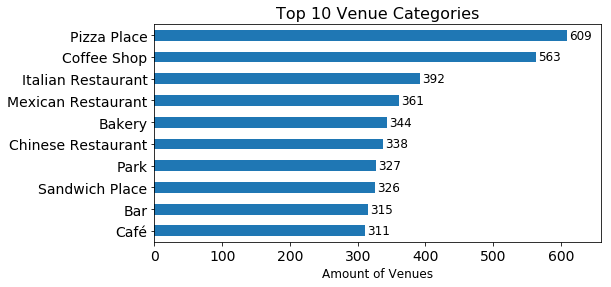

In [16]:
# Get top 10 most common venue types.
all_top10venues = all_venues['Venue Category'].value_counts().head(10)
x_max = all_top10venues.max()+50

# Plot top 10 most common venue types.
labels = all_top10venues.index
ax = all_top10venues.sort_values().plot.barh(figsize=(8,4))
# Mark each bar with the value.
for rect in ax.patches:
    y_value = rect.get_y() + rect.get_height() / 2
    x_value = rect.get_width()
    ax.annotate(x_value, (x_value, y_value), va='center',textcoords="offset points", xytext=(2,0), fontsize=12)  
# Set plot parameters and labels.
ax.set_xlim(0,x_max)
plt.title('Top 10 Venue Categories', fontsize=16)
plt.xlabel('Amount of Venues', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Lots of Pizza Places, which is likely attributable to New York and Chicago as both cities claim fame for their pizza.  Coffee Shops are also understandably common.  Italian, Mexican and Chinese are common non-continental cuisines and bakeries and bars are common as well.

Let's see if there is any correlation between these top 10 most common venue categories.

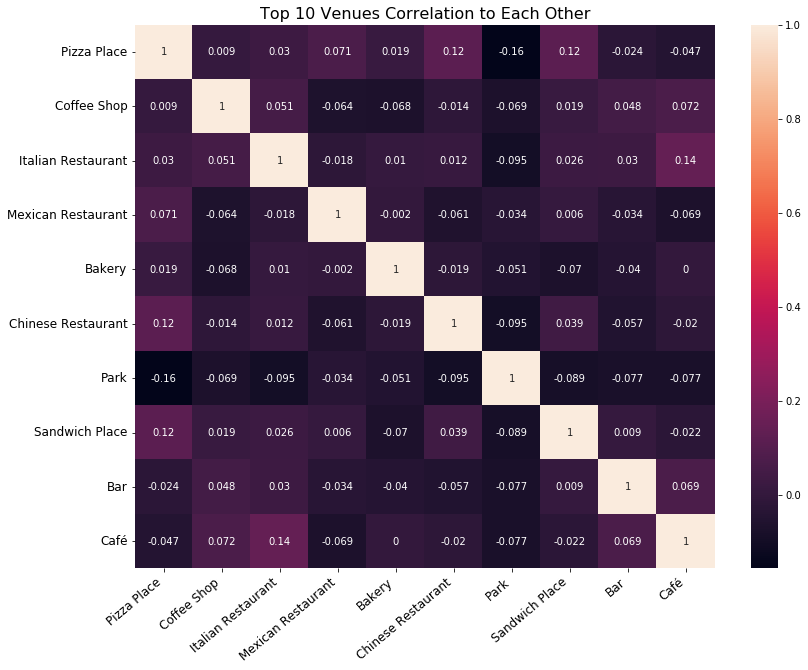

In [17]:
# Create DataFrame / correlation table for the top 10 venues.
all_grouped_corr = round(all_grouped.corr()[labels].loc[labels],3)

# Plot the correlation DataFrame as a Seaborn heatmap.
plt.figure(figsize=(13,10))
sns.heatmap(all_grouped_corr, annot=True)
plt.yticks(va='center', rotation=0,fontsize=12)
plt.xticks(ha='right', rotation=40,fontsize=12)
plt.title('Top 10 Venues Correlation to Each Other', fontsize=16)
plt.show()

There does not seem to be much correlation at all amongst the top 10 venue categories.  What two variables have the highest?

In [19]:
# Determine which of the venues above have the greatest correlation to each other.
# Run through the venues and gather the minimum and maximum values.
max_corr = 0

for col in all_grouped_corr.columns.values:
    max_ = all_grouped_corr[col].drop(col).max()
    min_ = all_grouped_corr[col].drop(col).min()
    # If the absolute value of the minimum is greater than the maximum, that is the greater correlation.
    if abs(min_) > max_:
        X = min_
    else:
        X = max_
    # Store the greatest correlation, it's respective venue and store as a DataFrame.
    if abs(X) > abs(max_corr):
        max_corr = X
        max_col = col
        df = all_grouped_corr[all_grouped_corr[max_col] == max_corr][col]
        
print(max_col + ' and ' + str(df.index.values[0]) + ' have the greatest correlation at ' + str(max_corr) + '.')

Pizza Place and Park have the greatest correlation at -0.157.


Of the top 10 venue categories, Pizza Place and Park have the greatest (although negative) correlation at -0.157.

What venues categories do these top 10 have the greatest correlation with?

In [20]:
# Determine the venues categories to which the top 10 venues above have the greatest correlation.
# Run through the venues and gather the minimum and maximum values.
max_corrs = []

for ind in labels:
    X = 0
    max_ = all_grouped.corr()[labels][ind].drop(ind).max()
    min_ = all_grouped.corr()[labels][ind].drop(ind).min()
    # If the absolute value of the minimum is greater than the maximum, that is the greater correlation.
    if abs(min_) > max_:
        X = min_
    else:
        X = max_
    # Store the greatest correlation in a list.
    max_corrs.append(X)
    
# Gather the venues with the greatest correlation to the top 10 venues.
features = [abs(all_grouped.corr()[labels][ind].drop(ind)).sort_values(ascending=False).index[0] for ind in labels]

# Create DataFrame.
pd.DataFrame(index=labels, data={'Dependant':features, 'Correlation':max_corrs}).sort_values('Correlation', ascending=False)

,Dependant,Correlation
Sandwich Place,ATM,0.398361
Chinese Restaurant,Dim Sum Restaurant,0.317655
Bar,Drugstore,0.315890
Café,College Stadium,0.266386
Coffee Shop,College Auditorium,0.253476
Italian Restaurant,Spa,0.225283
Pizza Place,Empanada Restaurant,0.200907
Mexican Restaurant,Strip Club,0.170390
Bakery,Dance Studio,0.135972
Park,Pizza Place,-0.156821


The greatest correlation is between Sandwich Places and ATM's, which is a good location.  Chinese correlated to Dim Sum (a style of Chineses cuisine) Restaurants also makes sense as does Cafés and Coffee Shops correlated to college facilities.  We have already noted the negative correlation between Parks and Pizza Places.  It is interesting that Mexican Restaurants' greatest correlation is to Strip Clubs.  

How many unique venue categories are in each city?

In [21]:
# Count and print number of unique venue categories per city.
for city in all_venues['City'].unique():
    print('There are {} unique venue categories in {}.'.format(len(all_venues[all_venues['City'] == city]['Venue Category'].unique()),city))

There are 302 unique venue categories in Chicago.
There are 320 unique venue categories in Los Angeles.
There are 428 unique venue categories in New York.
There are 265 unique venue categories in Toronto.


New York has nearly 100 more venue categories than the next city, Los Angeles.

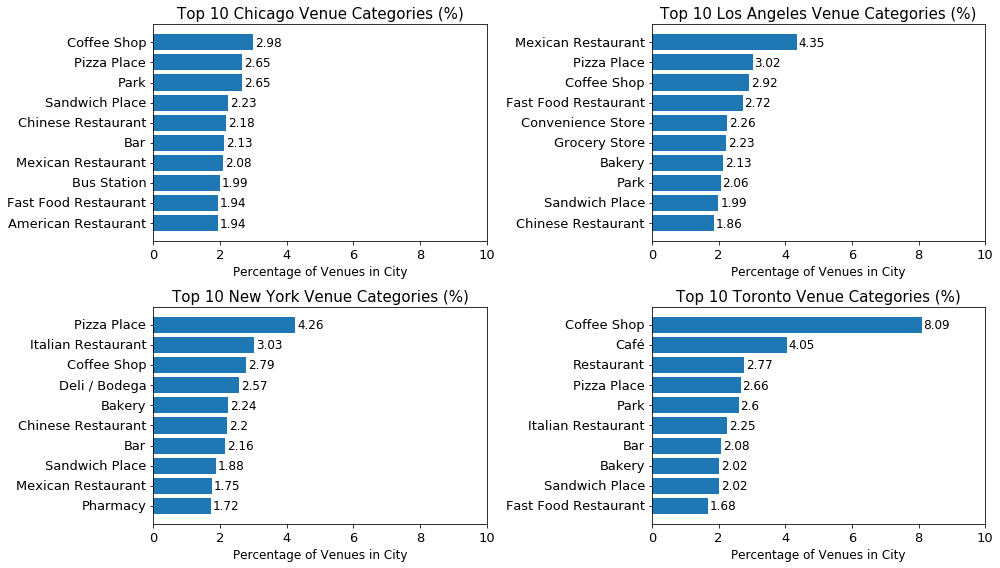

In [22]:
# Plot the top 10 venue categories per city by the their percentage of all venues.
fig = plt.figure(figsize=(14,8))
for i, city in enumerate(all_venues['City'].unique()):
    # Create a table for the venue counts.
    neigh_counts = all_venues[all_venues['City'] == city]['Venue Category'].value_counts()
    # Convert the table to percentages.
    top10venues = (neigh_counts.head(10)/neigh_counts.sum()*100).round(2)
    # Break cities into subplots.
    ax = fig.add_subplot(2, 2, i+1)
    ax.barh(top10venues.sort_values().index.values,top10venues.sort_values().values)
    # Mark each bar with the value.
    for rect in ax.patches:
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = rect.get_width()
        ax.annotate(x_value, (x_value, y_value), va='center',textcoords="offset points", xytext=(2,0), fontsize=12)
    # Set plot parameters and labels.
    ax.set_xlim(0,10)
    plt.title('Top 10 {} Venue Categories (%)'.format(city), fontsize=15)
    plt.xlabel('Percentage of Venues in City', fontsize=12)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13, va='center')
fig.tight_layout()
plt.show()

The highest percentages in Chicago are Coffee Shops, Parks and Pizza Places.  Coffee Shops and Parks are common most places, and Chicago does like its pizza. <br>
Los Angeles' most common venue is Mexican Restaurants, which makes sense given the proximity to the US / Mexico border and the heavy cultural influence. <br>
New York's most common venue is Pizza Places, which is not surprising as New Yorkers love their pizza.  Italian Restaurants and Delis are also very "New York" places. <br>
Coffee Shops account for a very high percentage of Toronto venues, nearly double that of the next category.  Some Italian, but not much ethnic influence outside of that.

Let's see which neighborhoods account for the greatest percentages of venues.

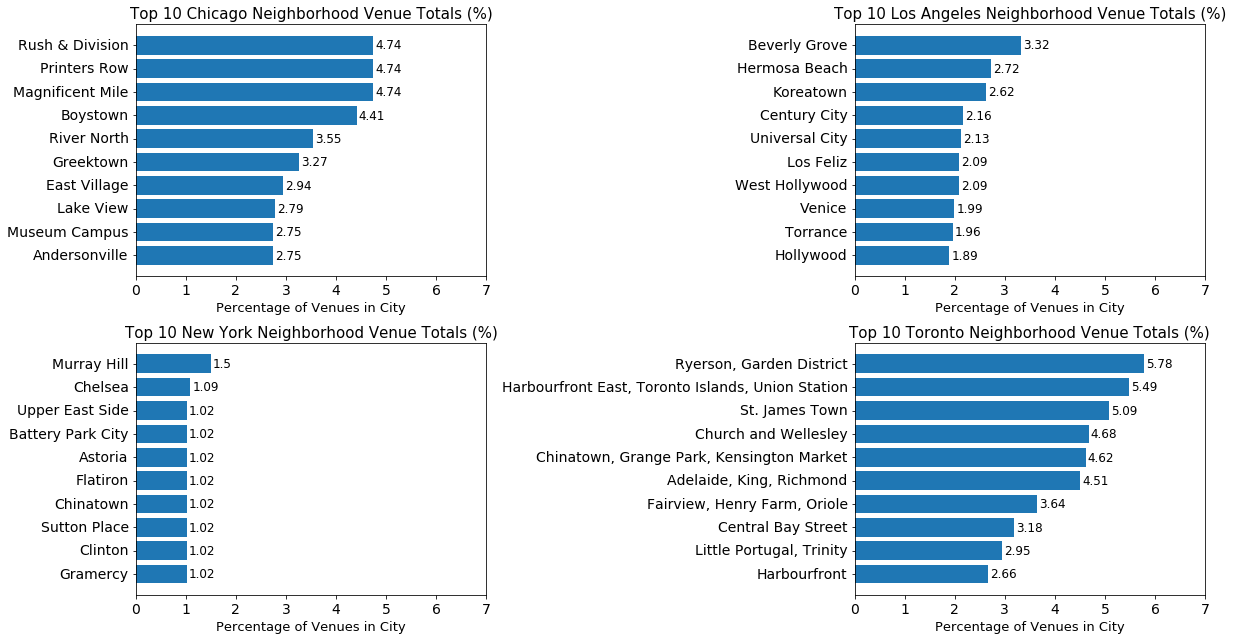

In [262]:
# Plot the top 10 neighborhoods per city by the their percentage of all venues. 
fig = plt.figure(figsize=(17,9))
for i, city in enumerate(all_venues['City'].unique()):
    # Create a table for the neighborhood counts.
    neigh_counts = all_venues[all_venues['City'] == city]['Neighborhood'].value_counts()
    # Convert the table to percentages.
    top10venues = (neigh_counts.head(10)/neigh_counts.sum()*100).round(2)
    # Break cities into subplots.
    ax = fig.add_subplot(2, 2, i+1)
    ax.barh(top10venues.sort_values().index.values,top10venues.sort_values().values)
    # Mark each bar with the value.
    for rect in ax.patches:
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = rect.get_width()
        ax.annotate(x_value, (x_value, y_value), va='center',textcoords="offset points", xytext=(2,0), fontsize=12)  
    # Set plot parameters and labels.
    ax.set_xlim(0,7)
    plt.title('Top 10 {} Neighborhood Venue Totals (%)'.format(city), fontsize=15)
    plt.xlabel('Percentage of Venues in City', fontsize=13)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14, va='center')
fig.tight_layout()
plt.show()

New York has a fairly minimal decline within their top neighborhoods and it plateaus quickly.  By contrast, Toronto has the most notable decline.  Also, Toronto neighborhoods are far less numerous than New York (103 / 306, respectively) and thus occupy a far greater percetnage of the total venues.  In this way, Toronto is fairly similar to Chicago.

### Clustering

Now we'll explore clustering with the city data to determine which US city Toronto is most like.

First, we'll update the "all_grouped" DataFrame.

In [28]:
# Add the City names back into "all_grouped" in the 'City' column.
all_grouped = all_venues[['Neighborhood', 'City']].join(all_grouped.set_index('Neighborhood'), on='Neighborhood', how='left').drop_duplicates(subset='Neighborhood',keep='first')
# Move the 'City' column from last to right after 'Neighborhood'.
fixed_columns = [all_onehot.columns[-1]] + list(all_onehot.columns[:-1])
all_onehot = all_onehot[fixed_columns]
# Check DataFrame.
all_grouped.head()

,Neighborhood,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Grand Boulevard,Chicago,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11,Printers Row,Chicago,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0
111,United Center,Chicago,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
147,Sheffield & DePaul,Chicago,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0
175,Humboldt Park,Chicago,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


I'll try k-Means Clsutering first.  I will create three data sets that pair Toronto with each of the US cities.  To account for class imbalance, I prefer undersampling.  I will use k=2 since there are two cities in each set and I want to determine how similar each city is to Toronto.  If the cities are clustered exclusively (i.e. Toronto in one cluster and the US city in the other) than the cities are not very alike.  The level of mixing in the clusters will give an indication of the similarities of the cities.

In [262]:
# Set values for sampling to match the lowest count of venues between Toronto and each of the three US cities.
tor_chi_sample_n = all_grouped[(all_grouped['City'] != 'New York') & (all_grouped['City'] != 'Los Angeles')].City.value_counts().min()
tor_NY_sample_n = all_grouped[(all_grouped['City'] != 'Chicago') & (all_grouped['City'] != 'Los Angeles')].City.value_counts().min()
tor_LA_sample_n = all_grouped[(all_grouped['City'] != 'New York') & (all_grouped['City'] != 'Chicago')].City.value_counts().min()

# Draw samples from each pairing of Toroto and each of the three US cities and save as DataFrames.
tor_chi_grouped = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=tor_chi_sample_n, replace=False),
                             all_grouped[all_grouped['City'] == 'Chicago'].sample(n=tor_chi_sample_n, replace=False)], axis=0).reset_index(drop=True)
tor_NY_grouped = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=tor_NY_sample_n, replace=False),
                            all_grouped[all_grouped['City'] == 'New York'].sample(n=tor_NY_sample_n, replace=False)], axis=0).reset_index(drop=True)
tor_LA_grouped = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=tor_LA_sample_n, replace=False),
                            all_grouped[all_grouped['City'] == 'Los Angeles'].sample(n=tor_LA_sample_n, replace=False)], axis=0).reset_index(drop=True)

# Make a list of all city/pair sample DataFrames.
toronto_compared = [tor_chi_grouped, tor_NY_grouped, tor_LA_grouped]

# Iterate over each sample DataFrame, perform clustering and print output.
for group in toronto_compared:
    # Drop 'Neighborhood' and 'City' columns.
    group_clustering = group.drop(columns=['Neighborhood', 'City'])
    # Create and fit KMeans object.
    KM = KMeans(n_clusters=2, random_state=0).fit(group_clustering)
    # Add cluster labels back in to original DataFrame
    group['Cluster ID'] = KM.labels_
    # Retreive US city in dataset
    for city in group['City'].unique():
        if city != 'Toronto':
            print(str('TORONTO COMPARED TO ' + city.upper()))
    # Print details from each cities clustering.
    for ID in group['Cluster ID'].unique():
        print('Cluster ' + str(ID))
        print(group[group['Cluster ID'] == ID]['City'].value_counts())
        print('Total: ' + str(group[group['Cluster ID'] == ID]['City'].value_counts().sum()))
        print('')
    print('----------------------------------')
    print('')

TORONTO COMPARED TO CHICAGO
Cluster 0
Chicago    86
Toronto    75
Name: City, dtype: int64
Total: 161

Cluster 1
Toronto    13
Chicago     2
Name: City, dtype: int64
Total: 15

----------------------------------

TORONTO COMPARED TO NEW YORK
Cluster 0
New York    97
Toronto     93
Name: City, dtype: int64
Total: 190

Cluster 1
Toronto     7
New York    3
Name: City, dtype: int64
Total: 10

----------------------------------

TORONTO COMPARED TO LOS ANGELES
Cluster 1
Los Angeles    94
Toronto        93
Name: City, dtype: int64
Total: 187

Cluster 0
Toronto        7
Los Angeles    6
Name: City, dtype: int64
Total: 13

----------------------------------



Not exactly what I was hoping for.  The clusters were not cleanly demarked by City and one cluster is roughly 10x the size of the other.  At a quick glance, Los Angeles neighborhoods are the most evenly clustered with Toronto's.

Let's see if we can determine characteristics of these clusters.

In [172]:
mylist = []

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

for pair in toronto_compared:
    TOR_US_DF = pair.copy()

    TOR_US_DF = TOR_US_DF.drop(columns=['Neighborhood', 'City'])

    fixed_columns = [TOR_US_DF.columns[-1]] + list(TOR_US_DF.columns[:-1])
    TOR_US_DF = TOR_US_DF[fixed_columns]

    TOR_US_DF = TOR_US_DF.groupby('Cluster ID').sum().reset_index()

    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Cluster ID']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Cluster ID'] = TOR_US_DF['Cluster ID']

    for ind in np.arange(TOR_US_DF.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TOR_US_DF.iloc[ind, :], num_top_venues)
    
    mylist.append(neighborhoods_venues_sorted)

In [173]:
# Toronto / Chicago Cluster.
mylist[0]

,Cluster ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Park,Café,Gym,Sandwich Place,Bakery,Chinese Restaurant,Liquor Store
1,1,Park,Basketball Court,Playground,Convenience Store,Construction & Landscaping,Food & Drink Shop,River,Bank,Coffee Shop,Restaurant


In [174]:
# Toronto / New York Cluster.
mylist[1]

,Cluster ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Coffee Shop,Pizza Place,Sandwich Place,Deli / Bodega,Park,Grocery Store,Bakery,Café,Bar,Chinese Restaurant
1,1,Park,Convenience Store,Playground,Food & Drink Shop,River,Coffee Shop,Restaurant,Tennis Court,Bank,Women's Store


In [175]:
# Toronto / Los Angeles Cluster.
mylist[2]

,Cluster ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Park,Convenience Store,Playground,Lake,Food,Food & Drink Shop,Other Repair Shop,Clothing Store,Bank,Construction & Landscaping
1,1,Coffee Shop,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Convenience Store,Grocery Store,Café,Trail,Construction & Landscaping,Bakery


Seems like the majority clusters for each Toronto/US city pairing are mostly restaurants. The minority clusters follow a pattern where the most common venue is parks, followed by convenience stores, playgrounds, rivers, gyms, banks and other non-eatery venues. That seems to be the primary demarkation between the clusters. Therefore, it is reasonable to think that the closer each cluster is to a 50/50 split between the two cities, the more similar the two cities are. <br> <br>
With that in mind, the Toronto / Los Angeles pairing in the previous k-Means clustering seems to be the closest to 50/50: <br>
<br>
TORONTO COMPARED TO LOS ANGELES<br>
Cluster 1<br>
Los Angeles: 94<br>
Toronto: 93<br>
Total: 187<br>
<br>
Cluster 0<br>
Toronto: 7<br>
Los Angeles: 6<br>
Total: 13<br>

Because I am using undersampling to account for the class imbalance, I want to run several iterations of sampling and application of k-Means. I will run the process 200 times and take the averages. 

In [89]:
# Set values for sampling to match the lowest count of venues between Toronto and each of the three US cities.
tor_chi_sample_n = all_grouped[(all_grouped['City'] != 'New York') & (all_grouped['City'] != 'Los Angeles')].City.value_counts().min()
tor_NY_sample_n = all_grouped[(all_grouped['City'] != 'Chicago') & (all_grouped['City'] != 'Los Angeles')].City.value_counts().min()
tor_LA_sample_n = all_grouped[(all_grouped['City'] != 'New York') & (all_grouped['City'] != 'Chicago')].City.value_counts().min()

chi_max = []
ny_max = []
la_max = []
chi_min = []
ny_min = []
la_min = []

for i in range(200):
    # Draw samples from each pairing of Toroto and each of the three US cities and save as DataFrames.
    tor_chi_grouped = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=tor_chi_sample_n, replace=False),
                                 all_grouped[all_grouped['City'] == 'Chicago'].sample(n=tor_chi_sample_n, replace=False)], axis=0).reset_index(drop=True)
    tor_NY_grouped = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=tor_NY_sample_n, replace=False),
                                all_grouped[all_grouped['City'] == 'New York'].sample(n=tor_NY_sample_n, replace=False)], axis=0).reset_index(drop=True)
    tor_LA_grouped = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=tor_LA_sample_n, replace=False),
                                all_grouped[all_grouped['City'] == 'Los Angeles'].sample(n=tor_LA_sample_n, replace=False)], axis=0).reset_index(drop=True)

    # Make a list of all city/pair sample DataFrames.
    toronto_compared = [tor_chi_grouped, tor_NY_grouped, tor_LA_grouped]

    # Iterate over each sample DataFrame and perform clustering.
    for group in toronto_compared:
        # Drop 'Neighborhood' and 'City' columns.
        group_clustering = group.drop(columns=['Neighborhood', 'City'])
        # Create and fit KMeans object.
        KM = KMeans(n_clusters=2, random_state=0).fit(group_clustering)
        # Add cluster labels back in to original DataFrame
        group['Cluster ID'] = KM.labels_
        # Save the majority and minority cluster labels.
        max_cluster = group[group['Cluster ID'] == group['Cluster ID'].mode()[0]]
        min_cluster = group[group['Cluster ID'] != group['Cluster ID'].mode()[0]]
        # Collect the value counts of the Toronto/US city pairing in both majority and minority clusters.
        if 'Chicago' in group['City'].unique():
            chi_max.append(round(max_cluster['City'].value_counts()/max_cluster['City'].count()*100,2))
            chi_min.append(round(min_cluster['City'].value_counts()/min_cluster['City'].count()*100,2))
        if 'New York' in group['City'].unique():
            ny_max.append(round(max_cluster['City'].value_counts()/max_cluster['City'].count()*100,2))
            ny_min.append(round(min_cluster['City'].value_counts()/min_cluster['City'].count()*100,2))
        if 'Los Angeles' in group['City'].unique():
            la_max.append(round(max_cluster['City'].value_counts()/max_cluster['City'].count()*100,2))
            la_min.append(round(min_cluster['City'].value_counts()/min_cluster['City'].count()*100,2))

# Create list of majority and minority clusters.           
all_ = ((chi_max, ny_max, la_max),(chi_min, ny_min, la_min))

# Print description of majority and minority clusters for each Toronto/US city pairing.
print('MAJORITY CLUSTER PERCENTAGE DESCRIPTION')
for i in all_[0]:
    df = pd.DataFrame(i).reset_index(drop=True)
    df = df[sorted(list(df.columns))]
    print(round(df.describe().drop('count'),2))
    print('')
    
print('MINORITY CLUSTER PERCENTAGE DESCRIPTION')
for i in all_[1]:
    df = pd.DataFrame(i).reset_index(drop=True)
    df = df[sorted(list(df.columns))]
    print(round(df.describe().drop('count'),2))
    print('')

MAJORITY CLUSTER PERCENTAGE DESCRIPTION
      Chicago  Toronto
mean    52.15    47.85
std      0.63     0.63
min     50.29    46.34
25%     51.83    47.47
50%     52.17    47.83
75%     52.53    48.17
max     53.66    49.71

      New York  Toronto
mean     52.37    47.63
std       0.64     0.64
min      49.75    46.20
25%      52.17    47.28
50%      52.46    47.54
75%      52.72    47.83
max      53.80    50.25

      Los Angeles  Toronto
mean        50.00    50.00
std          0.69     0.69
min         48.50    48.09
25%         49.46    49.47
50%         50.00    50.00
75%         50.53    50.54
max         51.91    51.50

MINORITY CLUSTER PERCENTAGE DESCRIPTION
      Chicago  Toronto
mean    23.13    77.33
std      6.50     7.20
min     11.11    63.64
25%     16.67    71.43
50%     25.00    75.00
75%     28.57    83.65
max     36.36   100.00

      New York  Toronto
mean     18.78    82.76
std       9.26     8.16
min       6.25    63.16
25%      13.33    76.47
50%      18.75    81

The means of the majority cluster for each Toronto/US city pairing are very close to 50/50, but Toronto/Los Angeles are exactly even at 50% of the cluster. The New York and Chicago pairings are close to 50/50, but both are around 52/48. The difference is small, but consistant. <br><br>
The differences in the minority clusters are more pronounced.  The Toronto/Los Angeles pair is much closer to 50/50 than any of the other pairs, which lends further credence to the presumption that Toronto is more like Los Angeles than either of the other US cities. <br><br>
Let's take a look at the distributions of the majority clusters.

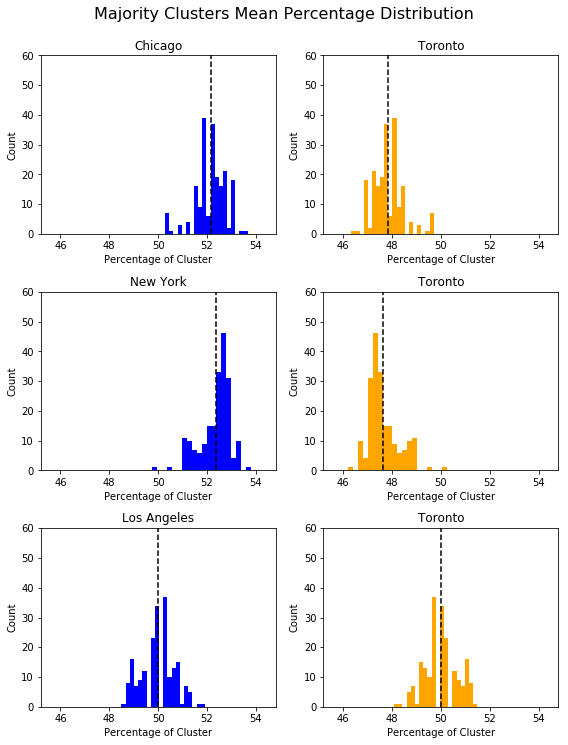

In [107]:
# Plot distribution of percentages in the majority clusters.
# Set bins variable.
b = 20
# Set counter variable to determine positioning in subplot.
i = 0

# Calculate max and min values in all city pairings.
axis_max = pd.concat((*chi_max, *ny_max, *la_max)).max()
axis_min = pd.concat((*chi_max, *ny_max, *la_max)).min()

# Plot the histogram.
plt.figure(figsize=(8,10))
for list_ in all_[0]:
    X = pd.concat(list_)
    # Set seperate subplot for each city in the pairing.
    for ind in X.index.unique():
        # Set color for specific for Toronto and the US city.
        if ind == 'Toronto':
            c = 'orange'
        else:
            c = 'blue'
        i += 1
        # Set plot parameters and labels.
        plt.subplot(3,2,i)
        plt.hist(X.loc[ind].values, bins=b,color=c)
        plt.axvline(X.loc[ind].values.mean(), color='black', linestyle='--')
        plt.title(ind)
        plt.ylim(0,60)
        plt.xlim(axis_min-1,axis_max+1)
        plt.xlabel('Percentage of Cluster')
        plt.ylabel('Count')
plt.suptitle("Majority Clusters Mean Percentage Distribution", size=16, y=1.03)
plt.tight_layout()
plt.show()

Some fairly normal distributions.  Toronto/Los Angeles seems the most even, and the mean for both is right at 50.  Standard deviation is very small for all pairs, roughly 0.65.

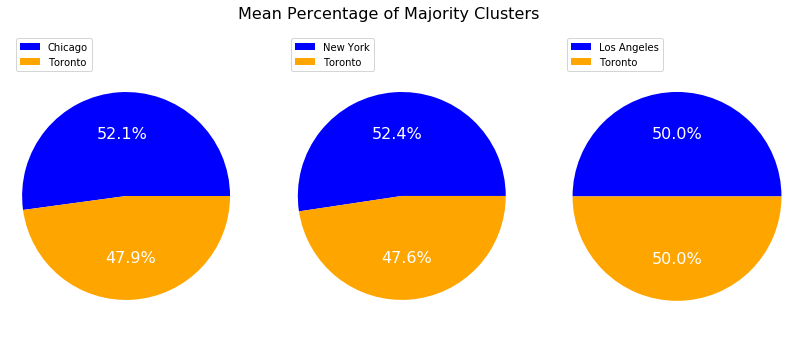

In [110]:
# Create pie chart for majority cluster means percentages.
axis = 0
plt.figure(figsize=(14,5))
for i in all_[0]:
    axis += 1
    plt.subplot(1,3,axis)
    df = pd.concat(i)
    df.groupby(df.index).mean().plot.pie(colors=['blue', 'orange'], autopct='%1.1f%%', textprops={'fontsize': 16, 'color':'w'})
    plt.legend(bbox_to_anchor=(0, 1.1), loc='upper left', ncol=1)
    plt.axis('equal') 
    plt.ylabel('')
    plt.xlabel('')
plt.suptitle("Mean Percentage of Majority Clusters", size=16, y=1.03)
plt.show()

Toronto and Los Angeles majority clusters are dead even on 50%.  The relationships between Toronto/New York and Toronto/Chicago are very similar, but Chicago is *slightly* more like Toronto than New York is.

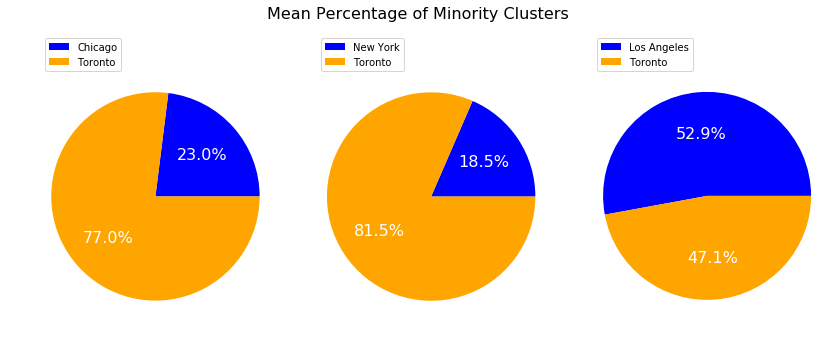

In [111]:
# Create pie chart for minority cluster means percentages.
axis = 0
plt.figure(figsize=(14,5))
for i in all_[1]:
    axis += 1
    plt.subplot(1,3,axis)
    df = pd.concat(i)
    df.groupby(df.index).mean().plot.pie(colors=['blue', 'orange'], autopct='%1.1f%%', textprops={'fontsize': 16, 'color':'w'})
    plt.legend(bbox_to_anchor=(0, 1.1), loc='upper left', ncol=1)
    plt.axis('equal') 
    plt.ylabel('')
    plt.xlabel('')
plt.suptitle("Mean Percentage of Minority Clusters", size=16, y=1.03)
plt.show()

As previously noted, the difference in the minority clusters are far more pronounced.  Toronto/Los Angeles are far closer to 50/50 than the other city pairs.  The relationships between Toronto/New York and Toronto/Chicago are again similar, but Toronto/Chicago is closer to 50/50 than Toronto/New York.

### Classification

The results of clustering point to Toronto/Los Angels as the closest pair, but I will also attempt classification. I will use the same dataset as in clustering, but use the cities as the labels to predict. I will check which Toronto neighborhoods were labeled incorrectly and what city label was applied. The most common incorrect label will be the city Toronto is most like. Logistic regression is an appropriate option since this is binary classification. This time, I will use oversampling.<br><br>
Let's see what we get...

In [147]:
# Logistic regression of the Toronto/US city neighborhoods pairs.
# Set sample variable.
sample_n = 5000
mylist = []

# for i in range(100):
# Draw samples from Toroto and each of the three US cities and save all as one DataFrames.
grouped_concat = pd.concat([all_grouped[all_grouped['City'] == 'Toronto'].sample(n=sample_n, replace=True),
                            all_grouped[all_grouped['City'] == 'Chicago'].sample(n=sample_n, replace=True),
                            all_grouped[all_grouped['City'] == 'New York'].sample(n=sample_n, replace=True),
                            all_grouped[all_grouped['City'] == 'Los Angeles'].sample(n=sample_n, replace=True)], axis=0).reset_index(drop=True)

# Set C-value array used for Grid Search.
param_grid = {'C':[0.001, 0.1, 1, 10, 100]}

# Create training and test sets
x_train, x_test, y_train, y_test = train_test_split(grouped_concat.drop(columns=['Neighborhood', 'City']), 
                                                    grouped_concat['City'])

# Build Logistic Regression model tuned with Grid Search.
LR = LogisticRegression(solver='liblinear',multi_class='auto')
LR_cv = GridSearchCV(LR,param_grid,cv=5)
# Fit model with training data.
LR_cv.fit(x_train, y_train)
# Predict labels.
labels = LR_cv.predict(x_test)

# Print model tuning and accuracy summaries.
print("Tuned Logistic Regression Parameters: {}".format(LR_cv.best_params_)) 
print("Accuracy score is {}".format(accuracy_score(labels, y_test)))
print("Best score is {}".format(LR_cv.best_score_))

# Combine test data and predicted labels into one DataFrame.
predict_df = grouped_concat.loc[x_test.index]
predict_df['Predict'] = labels
# Get percentage of Toronto neighborhoods labeled not as Toronto.
round(predict_df[predict_df['City'] == 'Toronto']['Predict'].value_counts()/len(predict_df[predict_df['City'] == 'Toronto']['Predict'])*100,2)

Tuned Logistic Regression Parameters: {'C': 100}
Accuracy score is 0.967
Best score is 0.973


Toronto        97.42
Los Angeles     2.58
Name: Predict, dtype: float64

96.7% accuracy is very good. We can see that 2.58% of Toronto neighborhoods were mislabeled as Los Angeles with none mislabeled as either New York or Chicago. The percentage is small, to be sure, but it does provide another indicator that Toronto is more like Los Angeles than either New York or Chicago.

## Summary

The indicators may not be especially profound, since all four cities are in North America, very large, economically developed and culturally diverse. With that said, the data does illustrate certain patterns and both classification and clustering point to Toronto having more in common with Los Angeles than either Chicago or New York. 